# Portfolio Optimization

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from returns import Returns
from risks import Risks
from optimizer import Optimizer


## Import data

In [12]:
df_raw_all = pd.read_hdf("dow30_full_selected.h5")


In [13]:
df_raw_prices = df_raw_all[["date", "tic", "close"]].rename(columns={"close": "price"})


In [14]:
df_prices = df_raw_prices.pivot(index="date", columns="tic", values="price").loc[
    "2009-01-02":"2020-09-02"
]


In [15]:
df_prices.index = pd.to_datetime(df_prices.index)

## Solve and check summary

In [16]:
def construct_portfolio(
    df_prices: pd.DataFrame,
    rfr: float,
    freq: str = "monthly",
    objective: str = "quadratic_utility",
    constraints: list = [],
    objective_kwargs: dict = {},
    constraint_kwargs: list = [],
) -> tuple:
    """
    Global function to solve portfolio problem

    Parameters
    ----------
    df_prices : pd.DataFrame
        DataFrame containing asset prices
    rfr : float
        Risk free rate of return
    freq : str, optional
        Frequency of portfolio rebalancing, by default "monthly"
    objective : str, optional
        Objective of investor, by default "quadratic_utility"
    constraint : list, optional
        Constraints of investor

    Returns
    -------
    tuple
        Tuple of dicts: weights and portfolio metrics
    """
    # Convert to same time scale
    if freq == "monthly":
        t = 12
        ts = 20
    elif freq == "yearly":
        t = 1
        ts = 252
    elif freq == "daily":
        t = 252
        ts = 1

    # Input data
    returns_generator = Returns(df_prices)
    df_returns = returns_generator.compute_returns(method="daily")
    # rfr_daily = ((1 + rfr) ** (1 / 252)) - 1
    # rfr_effective = ((1 + rfr) ** (1 / t)) - 1
    # df_returns["RF"] = rfr_daily
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=ts
    )
    # mu_return_geom["RF"] = rfr_effective
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=ts)

    # Construct optimizer
    portfolio_problem = Optimizer(
        mu_return_geom, cov_matrix, asset_names=list(mu_return_geom.index)
    )

    # print(portfolio_problem.objective_options())
    # print(portfolio_problem.constraint_options())

    portfolio_problem.clear_problem()
    portfolio_problem.add_objective(objective, **objective_kwargs)
    for c, kwarg in zip(constraints, constraint_kwargs):
        portfolio_problem.add_constraint(c, **kwarg)

    # Solve problem
    portfolio_problem.solve()

    return portfolio_problem.summary(rfr=0.01 / 12)


## Solve min. variance

In [32]:
begin = pd.to_datetime("2019-07-01")
end = pd.to_datetime("2020-07-01")
n_trades = int((pd.to_datetime("2021-09-01") - pd.to_datetime("2020-07-01"))/np.timedelta64(1, 'M'))
print(n_trades)

14


In [18]:
res_minvar = []
rtrn_minvar = []
np.random.seed(42)
for i in range(n_trades):
    w_minvar, perf_minvar = construct_portfolio(
        df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)],
        0.0000,
        "monthly",
        "min_variance",
        ["weight"],
        {},
        [{"weight_bound": (-1, 1), "sum": 1}],
    )
    print(perf_minvar)
    res_minvar.append(w_minvar)
    rtrn_minvar.append(perf_minvar["Expected return"])
df_weights_minvar = pd.DataFrame(res_minvar)


{'Expected return': 0.0015, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0795, 'Correlation': 0.8182, 'Sharpe Ratio': 0.0085}
{'Expected return': 0.0052, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.081, 'Correlation': 0.7728, 'Sharpe Ratio': 0.0539}
{'Expected return': 0.0109, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0808, 'Correlation': 0.7507, 'Sharpe Ratio': 0.1244}
{'Expected return': 0.0099, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0838, 'Correlation': 0.7527, 'Sharpe Ratio': 0.1083}
{'Expected return': 0.0133, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0877, 'Correlation': 0.7641, 'Sharpe Ratio': 0.1419}
{'Expected return': 0.0138, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0917, 'Correlation': 0.7614, 'Sharpe Ratio': 0.1413}
{'Expected return': 0.0144, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.097, 'Correlation': 0.7584, 'Sharpe Ratio': 0.1393}
{'Expected return': 0.0193, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1031, 'Correlatio

/Users/simontherien/Library/Mobile Documents/com~apple~CloudDocs/Projet Mitacs/portfolio-optim/risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


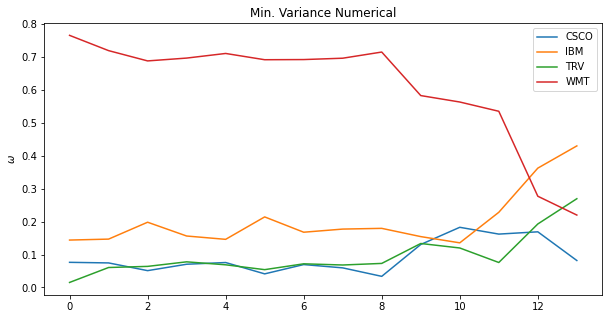

In [19]:
df_weights_minvar.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Numerical")
plt.show()


## Exact solution min. variance

In [20]:
res_gmv = []
for i in range(n_trades):
    returns_generator = Returns(df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)

    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    numerator = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets)))
    )
    gmv_w = numerator / denominator
    res_gmv.append(gmv_w)
df_weights_gmv = pd.DataFrame(res_gmv, columns=cov_matrix.columns)


/Users/simontherien/Library/Mobile Documents/com~apple~CloudDocs/Projet Mitacs/portfolio-optim/risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


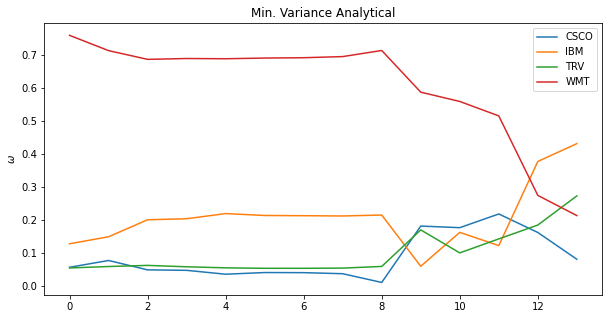

In [21]:
df_weights_gmv.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Analytical")
plt.legend(title="")
plt.show()


## Compare min. variance

In [22]:
# Analytical
df_weights_gmv.mean(axis=0)


tic
CSCO    0.087263
IBM     0.208102
TRV     0.099090
WMT     0.605545
dtype: float64

In [23]:
# Numerical
df_weights_minvar.mean(axis=0)


CSCO    0.091257
IBM     0.202671
TRV     0.096029
WMT     0.610043
dtype: float64

In [24]:
init_w = 1000000
cum_w_minvar = init_w * np.cumprod(1 + np.array(rtrn_minvar))
print("Final wealth ", cum_w_minvar[-1])


Final wealth  1333149.6757937702


## Solve quadratic

In [25]:
res_qu = []
rtrn_qu = []
np.random.seed(42)
for i in range(n_trades):
    w_qu, perf_qu = construct_portfolio(
        df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)],
        0.0000,
        "monthly",
        "quadratic_utility",
        ["weight"],
        {"aversion": 3},
        [{"weight_bound": (-4, 4), "sum": 1}],
    )
    print(perf_qu)
    res_qu.append(w_qu)
    rtrn_qu.append(perf_qu["Expected return"])
df_weights_qu = pd.DataFrame(res_qu)


{'Expected return': 0.0247, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.119, 'Correlation': 2.1509, 'Sharpe Ratio': 0.2006}
{'Expected return': 0.038, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1327, 'Correlation': 2.4696, 'Sharpe Ratio': 0.2804}
{'Expected return': 0.0515, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1417, 'Correlation': 2.6389, 'Sharpe Ratio': 0.3578}

/Users/simontherien/Library/Mobile Documents/com~apple~CloudDocs/Projet Mitacs/portfolio-optim/risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]



{'Expected return': 0.0472, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.1394, 'Correlation': 2.4662, 'Sharpe Ratio': 0.3323}
{'Expected return': 0.0447, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.1351, 'Correlation': 2.1553, 'Sharpe Ratio': 0.3248}
{'Expected return': 0.0439, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1359, 'Correlation': 1.9903, 'Sharpe Ratio': 0.3173}
{'Expected return': 0.0643, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.1609, 'Correlation': 2.422, 'Sharpe Ratio': 0.3943}
{'Expected return': 0.0831, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1787, 'Correlation': 2.7081, 'Sharpe Ratio': 0.4603}
{'Expected return': 0.0674, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1586, 'Correlation': 2.0792, 'Sharpe Ratio': 0.4198}
{'Expected return': 0.0701, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1155, 'Correlation': 1.9149, 'Sharpe Ratio': 0.5997}
{'Expected return': 0.1353, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.1922, 'Corre

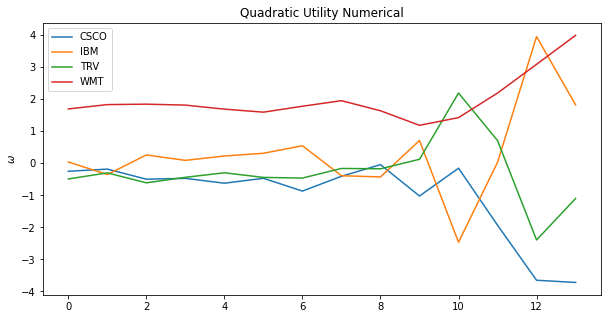

In [26]:
df_weights_qu.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Numerical")
plt.show()


## Exact solution quadratic

In [27]:
res_quadratic = []
for i in range(n_trades):
    returns_generator = Returns(df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)


    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    aversion = 3
    numerator_mvp = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator_mvp = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets)))
    )
    mvp_w = numerator_mvp / denominator_mvp
    numerator_tangency = np.matmul(mu_return_geom.T, inverse_cov_df)
    denominator_tangency = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, mu_return_geom))
    )
    tangency_w = numerator_tangency / denominator_tangency
    quadratic_w = mvp_w + (1 / aversion) * denominator_tangency * (tangency_w - mvp_w)
    res_quadratic.append(quadratic_w)
df_weights_quadratic = pd.DataFrame(res_quadratic, columns=cov_matrix.columns)


/Users/simontherien/Library/Mobile Documents/com~apple~CloudDocs/Projet Mitacs/portfolio-optim/risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


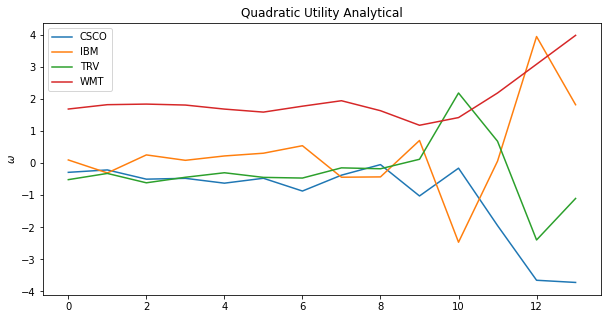

In [28]:
df_weights_quadratic.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Analytical")
plt.legend(title="")
plt.show()


## Compare quadratic

In [29]:
# Analytical
df_weights_quadratic.mean(axis=0)

tic
CSCO   -1.023215
IBM     0.319562
TRV    -0.277311
WMT     1.980964
dtype: float64

In [30]:
# Numerical
df_weights_qu.mean(axis=0)


CSCO   -1.020493
IBM     0.312443
TRV    -0.274043
WMT     1.982086
dtype: float64

In [31]:
cum_w_qu = init_w * np.cumprod(1 + np.array(rtrn_qu))
print("Final wealth ", cum_w_qu[-1])


Final wealth  6352066.039429354
